**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

##### Импорт дата сета

In [1]:
import numpy as np
import pandas as pd

import random
import pickle

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import chi2_contingency
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Input
DATA_PATH = "course_project_train.csv"
DATA_PATH_PREP = "course_project_train_prep.csv"

In [148]:
# output
TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part_train.csv'
TEST_PART_PATH = 'course_project_train_part_test.csv'
FINAL_PATH = 'DSizov_predictions.csv'
# Scaler
SCALER_FILE_PATH = 'scaler.pkl'

In [5]:
df=pd.read_csv(DATA_PATH)

In [6]:
def mediana(data,col):
    data.loc[data[col].isna()==True,col]=data[col].median()

In [7]:
def moda(data,col):
    data.loc[data[col].isna()==True,col]=data[col].mode()[0]

In [8]:
# Функция выводит название переменной и количество наблюдений для данной переменной 
def checking(data,col):
    a=0
    for i in data[col].unique():
        if type(i)==np.nan:
            _count=len(data.loc[data[col].isna()==True,col])
            print(f'{i} = {_count}')
        else:
            _count=data.loc[data[col]==i, col].count()
            print(f'{i} = {_count}')
        a+=_count
    print('Проверочная сумма',a)

In [9]:
# данный алгоритм присваивает строковым значениям Years in current job 
# целочисленные значения 
def yearssmap(data):
    data['Years in current job']=data['Years in current job'].map({'10+ years':10,
                                    '8 years':8,
                                    '6 years':6,
                                    '7 years':7,
                                    '5 years':5,
                                    '1 year':1,
                                    '< 1 year':0,
                                    '4 years':4,
                                    '3 years':3,
                                    '2 years':2,
                                    '9 years':9
                                    }).astype(np.int64)

In [10]:
# Функция преобразует строковые значения в числовую переменную, присваивая ей числовые значения от 0 с шагом 1
def converting(data, col, pattern=None, _type=np.int64):
    if pattern==None:
        _dict={}
        _iter=0
        for names in data[col].unique():
            _dict[names]=_iter
            _iter+=1
        return data[col].map(_dict).astype(_type), _dict
    else:
        _dict=pattern
        return data[col].map(_dict).astype(_type)

In [11]:
# замена пропущенных значений линейной регрессией
# из регулярных колонок убрал  'Current Loan Amount', так как это значение также буду чистить
def regres(df,y,reg_model=None, reg_cols=['Home Ownership', 
                              'Tax Liens', 
                              'Number of Open Accounts', 
                              'Years of Credit History',
                              'Maximum Open Credit',
                              'Number of Credit Problems',
                              'Purpose', 'Term',
#                               'Current Loan Amount',
                              'Current Credit Balance',
                              'Monthly Debt',
#                               'Credit Default'
                                         ]):
    if reg_model==None:
        db=df.copy()
        db_test=db.loc[db[y].isna()==False]
        db_tofill=db.loc[db[y].isna()==True]
        
        X_train=db_test[reg_cols]
        X_test=db_tofill[reg_cols]
        y_train=db_test[y]
        
        regression=LinearRegression()
        reg=regression.fit(X_train,y_train)
        y_pred=reg.predict(X_test)
        db.loc[db[y].isna()==True,y]=y_pred
        df=db.copy()
        return df, reg
    
# Если у нас уже была обучена модель, то мы берем за основу ее
    else:
        db=df.copy()
        db_tofill=db.loc[db[y].isna()==True]
        X_test=db_tofill[reg_cols]
        
        y_pred=reg_model.predict(X_test)
        db.loc[db[y].isna()==True,y]=y_pred
        df=db.copy()
        return df

##### Обзор обучающего дата сета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [12]:
df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [13]:
df.shape

(7500, 17)

In [14]:
df.describe().round(0)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.0,7500.0,7500.0,7500.0,7.500000e+03,7500.0,3419.0,7486.0,7500.0,7500.0,7500.0,5943.0,7500.0
mean,1366392.0,0.0,11.0,18.0,9.451540e+05,0.0,35.0,0.0,11873177.0,289833.0,18314.0,1151.0,0.0
std,845339.0,0.0,5.0,7.0,1.602622e+07,0.0,22.0,0.0,31926123.0,317871.0,11927.0,1604.0,0.0
min,164597.0,0.0,2.0,4.0,0.000000e+00,0.0,0.0,0.0,11242.0,0.0,0.0,585.0,0.0
25%,844341.0,0.0,8.0,14.0,2.792300e+05,0.0,16.0,0.0,180169.0,114256.0,10068.0,711.0,0.0
50%,1168386.0,0.0,10.0,17.0,4.781590e+05,0.0,32.0,0.0,309573.0,209323.0,16076.0,731.0,0.0
75%,1640137.0,0.0,14.0,22.0,7.935020e+05,0.0,50.0,0.0,519882.0,360406.0,23818.0,743.0,1.0
max,10149344.0,7.0,43.0,58.0,1.304726e+09,7.0,118.0,4.0,99999999.0,6506797.0,136679.0,7510.0,1.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

##### Проверяем на наличие пустых значений

In [16]:
len(df)-df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

###### Промежуточный вывод


Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score имеют пропущенные значения
Home Ownership - тип признака 'object', а должен быть 'integer'

##### Проверяем признак 'Years in current job' 

In [17]:
checking(df,'Years in current job')

nan = 0
10+ years = 2332
8 years = 339
6 years = 426
7 years = 396
5 years = 516
1 year = 504
< 1 year = 563
4 years = 469
3 years = 620
2 years = 705
9 years = 259
Проверочная сумма 7129


##### Заменяем нулевые значения модой

In [18]:
ind=df.loc[df['Years in current job'].isna()==True,'Years in current job'].index

In [19]:
moda(df,'Years in current job')

In [20]:
df.iloc[ind]['Years in current job']

0       10+ years
22      10+ years
24      10+ years
58      10+ years
60      10+ years
          ...    
7368    10+ years
7409    10+ years
7413    10+ years
7439    10+ years
7498    10+ years
Name: Years in current job, Length: 371, dtype: object

##### Переводим значения из из строки в числовую переменную

In [21]:
df['Years in current job'].unique()

array(['10+ years', '8 years', '6 years', '7 years', '5 years', '1 year',
       '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [22]:
yearssmap(df)

In [23]:
checking(df,'Years in current job')

10 = 2703
8 = 339
6 = 426
7 = 396
5 = 516
1 = 504
0 = 563
4 = 469
3 = 620
2 = 705
9 = 259
Проверочная сумма 7500


##### Преобразуем 'Home Ownership' из строки в числовую переменную

In [24]:
checking(df,'Home Ownership')

Own Home = 647
Home Mortgage = 3637
Rent = 3204
Have Mortgage = 12
Проверочная сумма 7500


In [25]:
df['Home Ownership'], HomeOwnershipPattern = converting(df,'Home Ownership')

In [26]:
HomeOwnershipPattern

{'Own Home': 0, 'Home Mortgage': 1, 'Rent': 2, 'Have Mortgage': 3}

In [27]:
checking(df,'Home Ownership')

0 = 647
1 = 3637
2 = 3204
3 = 12
Проверочная сумма 7500


##### Анализируем Purpose

In [28]:
df['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

In [29]:
checking(df,'Purpose')

debt consolidation = 5944
other = 665
home improvements = 412
take a trip = 37
buy a car = 96
small business = 26
business loan = 129
wedding = 15
educational expenses = 10
buy house = 34
medical bills = 71
moving = 11
major purchase = 40
vacation = 8
renewable energy = 2
Проверочная сумма 7500


In [30]:
df['Purpose'], PurposePatern = converting(df, 'Purpose')

In [31]:
PurposePatern

{'debt consolidation': 0,
 'other': 1,
 'home improvements': 2,
 'take a trip': 3,
 'buy a car': 4,
 'small business': 5,
 'business loan': 6,
 'wedding': 7,
 'educational expenses': 8,
 'buy house': 9,
 'medical bills': 10,
 'moving': 11,
 'major purchase': 12,
 'vacation': 13,
 'renewable energy': 14}

##### Анализируем Term

In [32]:
checking(df,'Term')

Short Term = 5556
Long Term = 1944
Проверочная сумма 7500


В признаке Term наблюдаем только два типа значений. Целесообразно перевести эти значения в 0 или 1

In [33]:
df['Term'], termpattern=converting(df,'Term')
termpattern

{'Short Term': 0, 'Long Term': 1}

In [34]:
checking(df,'Term')

0 = 5556
1 = 1944
Проверочная сумма 7500


##### Анализируем признак Months since last delinquent

In [35]:
df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

Проверим количество пустых значений по отношению к общему количеству значений.

In [36]:
(df['Months since last delinquent'].isna().sum()/df.shape[0])*100

54.413333333333334

54% наблюдений для признака 'Months since last delinquent' отсутствуют. Какое бы значение не присвоили отсутствующим признакам, они будут в значительной мере влиять на точность конечной модели, поэтому данный признак удаляю.

In [37]:
df.drop(['Months since last delinquent'],axis=1,inplace=True)

##### Анализируем признак Bankruptcies

In [38]:
df['Bankruptcies'].unique()

array([ 1.,  0.,  3., nan,  2.,  4.])

In [39]:
checking(df,'Bankruptcies')

1.0 = 786
0.0 = 6660
3.0 = 7
nan = 0
2.0 = 31
4.0 = 2
Проверочная сумма 7486


Заменяем пропущенные значения модой

In [40]:
moda(df,'Bankruptcies')

In [41]:
checking(df,'Bankruptcies')

1.0 = 786
0.0 = 6674
3.0 = 7
2.0 = 31
4.0 = 2
Проверочная сумма 7500


## Преобразование численных переменных

##### Проверяем пропущенные значения

In [42]:
len(df)-df.count()

Home Ownership                  0
Annual Income                1557
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                 1557
Credit Default                  0
dtype: int64

#### Проверим значения на выбросы

In [43]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default'],
      dtype='object')

Выпишем колонки, которые необходимо проверить на выбросы - те, которые имеют непрерывные значения

In [44]:
col_check=['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [45]:
len(col_check)

8

Построим графики boxplot для выбранных колонок

In [46]:
x=np.linspace(1,11,num=11)
y=np.linspace(1,11,num=11)

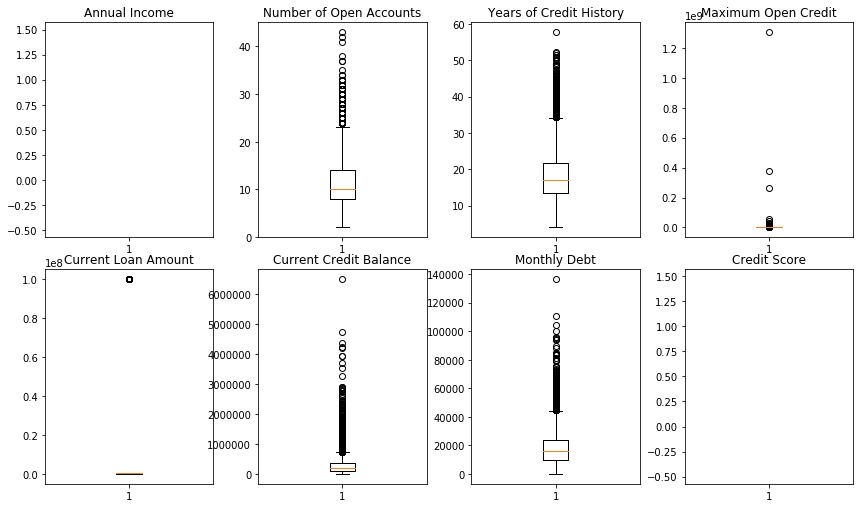

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 7))
fig.tight_layout() 
for en,pl in enumerate(axes.flatten()):
    pl.boxplot(df[col_check[en]])
    pl.set_title(col_check[en])
        

##### Проанализируем и убререм выпады для Current Loan Amount

In [48]:
df['Current Loan Amount'].sort_values()

1404       11242.0
4467       21472.0
2735       21472.0
7144       21516.0
5861       21560.0
           ...    
4384    99999999.0
732     99999999.0
4374    99999999.0
4555    99999999.0
0       99999999.0
Name: Current Loan Amount, Length: 7500, dtype: float64

In [49]:
df.loc[df['Current Loan Amount']==99999999.0,'Current Loan Amount'].count()

870

Заменяем значения 99999999.0 признака 'Current Loan Amount' на None для того, чтобы далее используя унифицированный алгоритм регрессии заменить их на значения, найденные с помощью линейной регрессии

In [50]:
df.loc[df['Current Loan Amount']==99999999.0,'Current Loan Amount']=None

CLA_ind=df.loc[df['Current Loan Amount'].isna(),'Current Loan Amount'].index
CLA_ind

Int64Index([   0,    2,    6,   22,   27,   30,   31,   46,   61,   67,
            ...
            7340, 7344, 7376, 7431, 7439, 7441, 7445, 7464, 7475, 7497],
           dtype='int64', length=870)

In [51]:
df.iloc[CLA_ind]['Current Loan Amount']

0      NaN
2      NaN
6      NaN
22     NaN
27     NaN
        ..
7441   NaN
7445   NaN
7464   NaN
7475   NaN
7497   NaN
Name: Current Loan Amount, Length: 870, dtype: float64

In [52]:
df['Current Credit Balance'].describe().round()

count       7500.0
mean      289833.0
std       317871.0
min            0.0
25%       114256.0
50%       209323.0
75%       360406.0
max      6506797.0
Name: Current Credit Balance, dtype: float64

In [53]:
df['Current Loan Amount'].describe().round()

count      6630.0
mean     309024.0
std      182294.0
min       11242.0
25%      172744.0
50%      265826.0
75%      430100.0
max      789030.0
Name: Current Loan Amount, dtype: float64

##### Подчистим Maximum Open Credit

In [54]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

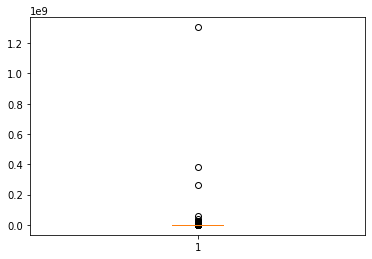

In [55]:
plt.boxplot(df['Maximum Open Credit']);

In [56]:
(df['Maximum Open Credit'].sort_values()[-500:]/10).round(2)

1675       151899.0
1849       151912.2
3225       151938.6
3458       152332.4
948        152506.2
           ...     
2763      4092389.4
2023      5756256.0
2617     26551287.4
44       38005228.8
617     130472617.0
Name: Maximum Open Credit, Length: 500, dtype: float64

In [57]:
y=df['Maximum Open Credit'].sort_values()
x=np.linspace(1,7500,num=7500)

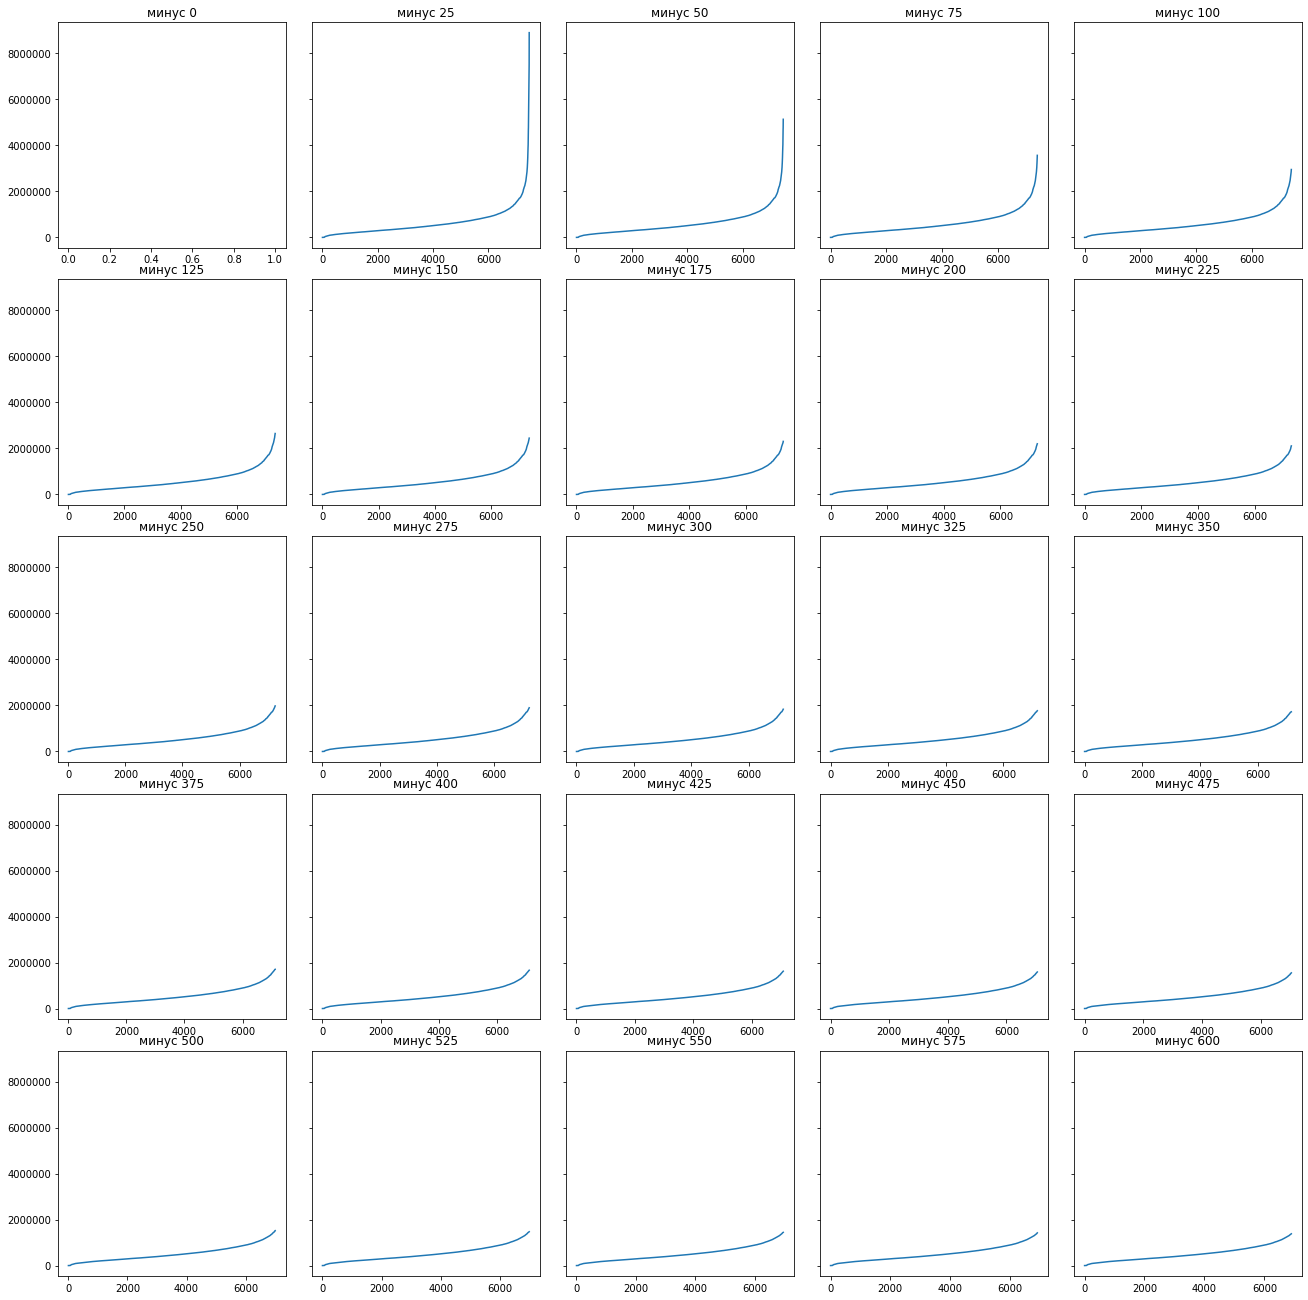

In [58]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(18, 18), sharey=True)
fig.tight_layout() 
coeff=25
for en,pl in enumerate(axes.flatten()):
    pl.plot(x[:-en*coeff],y[:-en*coeff])
    pl.set_title(f'минус {en*coeff}')
        

# plt.plot(x[:-100],y[:-100])

Из графика видно, что значения признака 'Maximum Open Credit'от меньшего к большему растут по экспоненте. Найдем максимвльные из них и заменим медианой, чтобы сгладить выбросы 

In [59]:
df.loc[df['Maximum Open Credit']>=10**7,'Maximum Open Credit'].count()

19

In [60]:
# Принимаем за границу выбросов значения больше 10**7 степени и заменяем их на медианные
df.loc[df['Maximum Open Credit']>=10**7,'Maximum Open Credit']=df['Maximum Open Credit'].median()

# Заменим нулевые значения на медианные
df.loc[df['Maximum Open Credit']==0,'Maximum Open Credit']=df['Maximum Open Credit'].median()

In [61]:
df['Maximum Open Credit'].nunique()

6945

##### Подчистим от выбросов Credit score

In [62]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

У нас есть скопление значений выше 2000 тысяч. 
Данные значения делим на 10.

In [63]:
def CredSc(data):
    data.loc[data['Credit Score']>2000,'Credit Score']=data.loc[data['Credit Score']>2000,'Credit Score']/10

In [64]:
CredSc(df)

### Линейная регрессия

Пропущенные численные непрерывные признаки заменим с помощью алгоритма линейной регрессии. При этом модель линейной регрессии выведем отдельно в переменную для того, чтобы можно было повторить преобразования с тестовым дата сетом

In [65]:
df, CrScore_Pat = regres(df,'Credit Score')

In [66]:
df, AnInc_Pat = regres(df,'Annual Income')

In [67]:
df, CLA_Pat = regres(df,'Current Loan Amount')

In [68]:
len(df)-df.count()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

Подчистим 'Current Credit Balance'

In [69]:
df.loc[df['Current Credit Balance']==0,'Current Credit Balance']=df['Current Loan Amount']
df.loc[df['Current Credit Balance']>=df['Current Credit Balance'].max()*0.3,'Current Credit Balance']=df['Current Loan Amount']

### Группировка некоторых значений

Группировка значений повысила коллениарность признаков  и снизила точность модели. В связи с этим группировку в конечной модели не применял

### Преобразуем переменные в dummie

In [70]:
df['ID'] = df.index.tolist()

In [71]:
df.nunique()

Home Ownership                  4
Annual Income                7035
Years in current job           11
Tax Liens                       8
Number of Open Accounts        39
Years of Credit History       408
Maximum Open Credit          6945
Number of Credit Problems       8
Bankruptcies                    5
Purpose                        15
Term                            2
Current Loan Amount          6255
Current Credit Balance       6642
Monthly Debt                 6716
Credit Score                 1717
Credit Default                  2
ID                           7500
dtype: int64

Выберем переменные, которые стоит преобразовать в dummie переменные

In [72]:
possible_dummies=['Home Ownership','Number of Credit Problems','Bankruptcies','Purpose']

In [73]:
for name in possible_dummies:
    print(f'{name} \n уникальные переменные {df[name].unique()}\n тип переменных {df[name].dtypes}\n \n ')

Home Ownership 
 уникальные переменные [0 1 2 3]
 тип переменных int64
 
 
Number of Credit Problems 
 уникальные переменные [1. 0. 3. 2. 6. 4. 5. 7.]
 тип переменных float64
 
 
Bankruptcies 
 уникальные переменные [1. 0. 3. 2. 4.]
 тип переменных float64
 
 
Purpose 
 уникальные переменные [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 тип переменных int64
 
 


### Преобразуем все переменные в int64 и создаем dummie переменные

In [74]:
df[possible_dummies]=df[possible_dummies].astype(np.int64)
for cat_colname in possible_dummies:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

# Выделение целевой переменной и групп признаков


In [75]:
df_base = pd.read_csv(DATA_PATH)

In [76]:
# убираем целевую перменную в TARGET_NAME
TARGET_NAME = 'Credit Default'
# выписываем имена  признаков  исходного дата сета
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).drop(['Months since last delinquent']).tolist()
# выписываем имена признаков нового дата сета таким образом, что из подготовленного 
# дата сета выкидываем имена старого дата сета и имя целевой переменной
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES+['ID']).tolist()
FTR=BASE_FEATURE_NAMES+NEW_FEATURE_NAMES

### Анализ целевой переменной

#### Обзор распределения


In [77]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

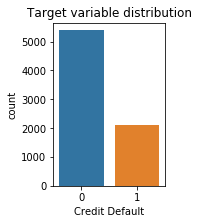

In [78]:
plt.figure(figsize=(2, 3))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

In [79]:
v0=df[TARGET_NAME].value_counts()[0]
v1=df[TARGET_NAME].value_counts()[1]
v1_w=(v1/(v0+v1))*100
v0_w=(v0/(v0+v1))*100
print (f'Доля значений 0: {round(v0_w,1)}%')
print (f'Доля значений 1: {round(v1_w,1)}%')
print (f'отношение 0/1: {round(v0_w/v1_w,1)}')

Доля значений 0: 71.8%
Доля значений 1: 28.2%
отношение 0/1: 2.5


Значений '1' в 2,5 раза меньше чем '0', следовательно при при обучении модели размеры выборок необходимо будет выровнять

#### Корреляция с базовыми признаками и с новыми признаками


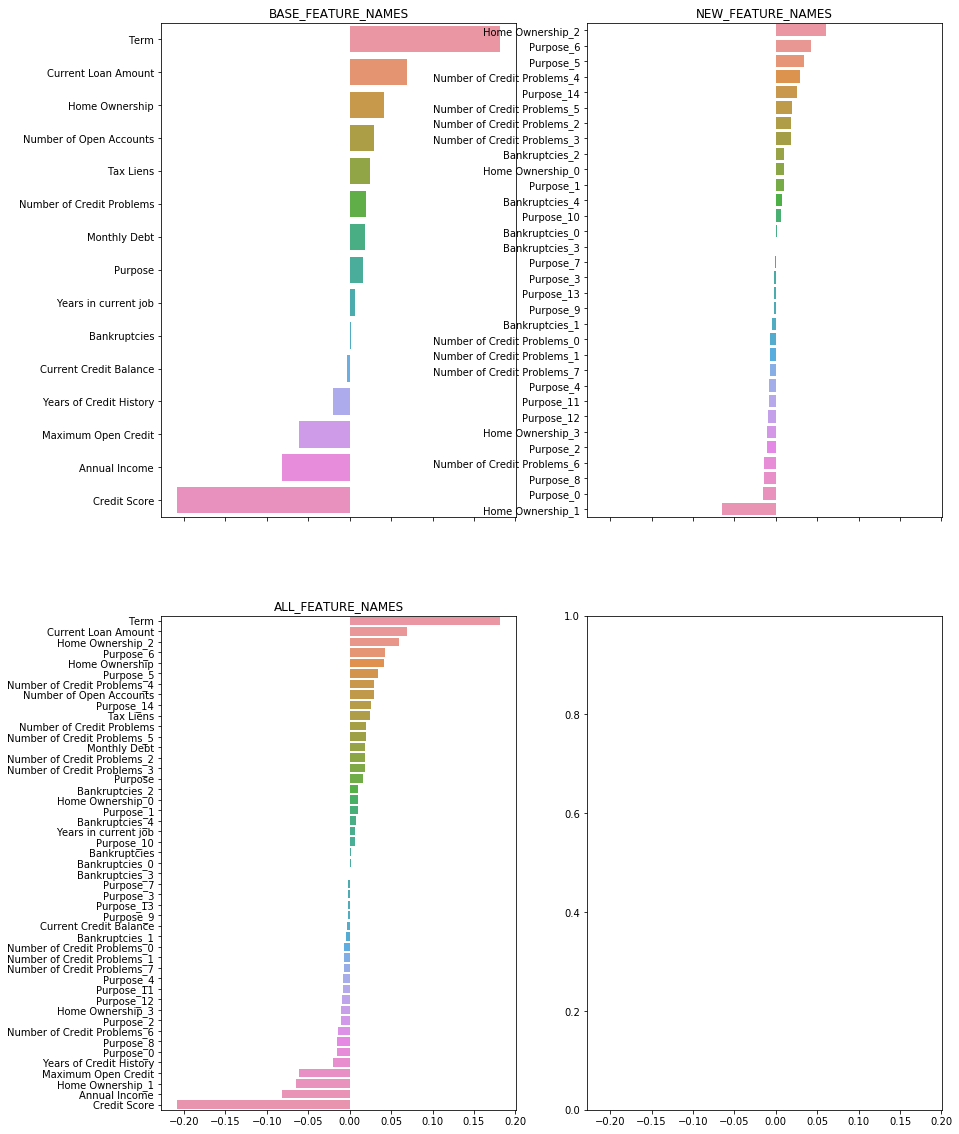

In [80]:
#  Строим график корреляций
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 20), sharex=True)
ax1,ax2, ax3, ax4=axes.flatten()

corr_with_target_base = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
corr_with_target = df[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
corr_with_target_tog = df[NEW_FEATURE_NAMES + BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

sns.barplot(x=corr_with_target_base.values, y=corr_with_target_base.index, ax=ax1)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, ax=ax2)
sns.barplot(x=corr_with_target_tog.values, y=corr_with_target_tog.index, ax=ax3)


ax1.set_title('BASE_FEATURE_NAMES')
ax2.set_title('NEW_FEATURE_NAMES')
ax3.set_title('ALL_FEATURE_NAMES')
plt.show()


#### Оценка признаков в разрезе целевой переменной


Выберем категориальные признаки с количеством категорий не больше 15

In [81]:
df[BASE_FEATURE_NAMES].nunique()

Home Ownership                  4
Annual Income                7035
Years in current job           11
Tax Liens                       8
Number of Open Accounts        39
Years of Credit History       408
Maximum Open Credit          6945
Number of Credit Problems       8
Bankruptcies                    5
Purpose                        15
Term                            2
Current Loan Amount          6255
Current Credit Balance       6642
Monthly Debt                 6716
Credit Score                 1717
dtype: int64

In [82]:
SHORT_FUTURES_NAMES=[]
for col in BASE_FEATURE_NAMES:
    if df[col].nunique()<=15:
        SHORT_FUTURES_NAMES.append(col)
SHORT_FUTURES_NAMES

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term']

Оценим категриальные признаки в разрезе целевой переменной

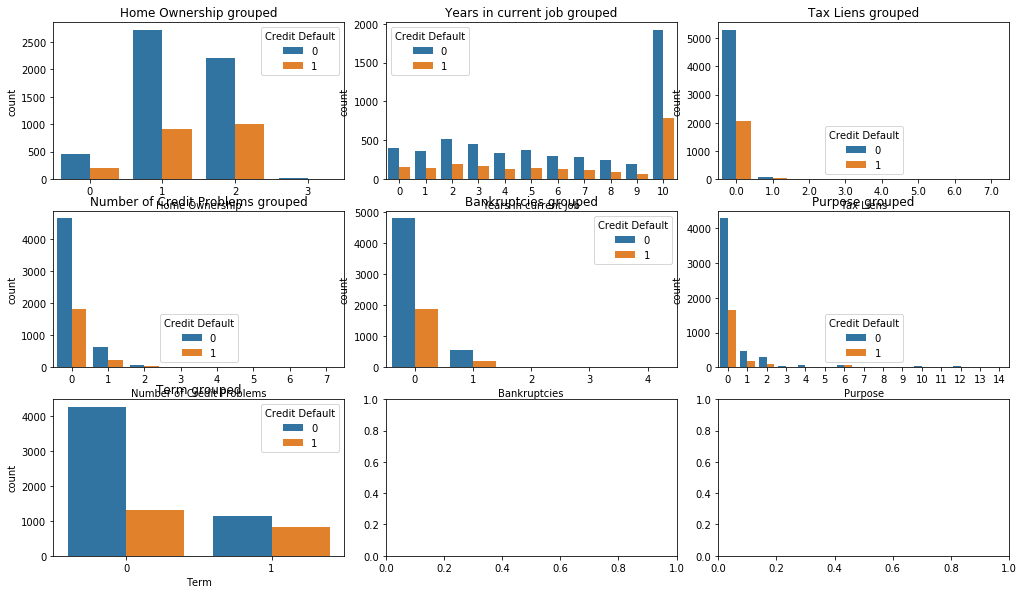

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 8))
fig.tight_layout() 

for en,axi in enumerate(axes.flatten()):
    if en>6:
        continue
        
    nam=SHORT_FUTURES_NAMES[en]

    sns.countplot(x=nam, hue=TARGET_NAME, data=df, ax=axi)
    axi.set_title(f'{nam} grouped')

plt.show();

Обратим внимание на признак Home ownership

Значения переменных Home ownership {'Own Home': 0, 'Home Mortgage': 1, 'Rent': 2, 'Have Mortgage': 3}

Изучив получившийся график, видно, что значения 1 (Home Mortgage) и 2 (Rent) признака 'Home Ownership' имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 1 и 2 признака 'Home Ownership' в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

##### Сформируем выборку и рассчитаем наблюдаемые частоты


In [84]:
home_own_and_target_s = df.loc[df['Home Ownership'].isin([1, 2]),
                               ['ID', 'Home Ownership', TARGET_NAME]
                              ].sample(1000)

In [85]:
table = home_own_and_target_s.pivot_table(values='ID', index='Home Ownership',
                              columns= TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
1,410,123
2,319,148


Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона


In [86]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
round(p,7)

0.0022294

В соответствии с критерием Хи-квадрат Пирсона уровень значимости 0.001023, что  меньше уровня значимости 𝛼: 0.05. Следовательно нулевая гипотеза о том, что ожидаемые и наблюдаемые частоты согласованы отвергается.

In [87]:
CONT_FUTURES_NAMES=[]
for col in BASE_FEATURE_NAMES:
    if df[col].nunique()>=10:
        CONT_FUTURES_NAMES.append(col)
CONT_FUTURES_NAMES

['Annual Income',
 'Years in current job',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Purpose',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

### Проверим распределения на нормальность с помощью критерия Шапиро-Уилка

In [88]:
for i in CONT_FUTURES_NAMES:
    print(shapiro(df[i].sample(1000))[1])

9.018080705807578e-36
5.357269048335831e-29
6.690898579208609e-23
7.720687116249471e-18
2.6932956484322984e-42
0.0
1.1022942603809157e-20
1.2761414701834777e-31
1.6739269415448237e-26
1.838302200787674e-30


p_value во всех случаях равены или близки 0, следовательно значения признаков не имеют нормального распределения

### Анализ признакового пространства

### Нормализуем данные

##### Визуально проверим данные на нормальность распределения с помощью QQ-графика

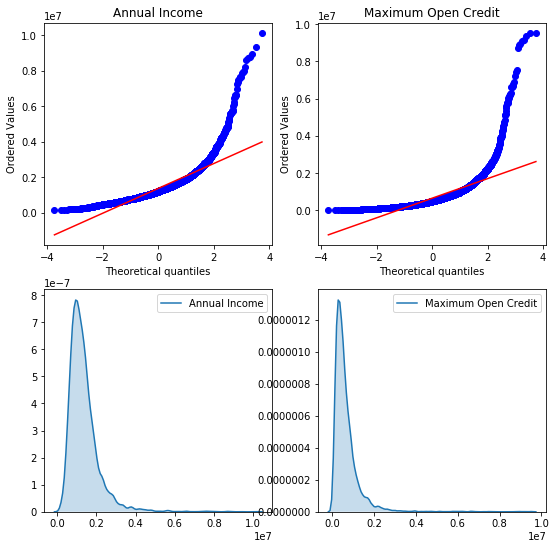

In [89]:
fig, axes=plt.subplots(ncols=2, nrows=2, figsize=(9,9))
ax1, ax2, ax3, ax4 = axes.flatten()
probplot(df['Annual Income'], dist='norm', plot=ax1)
ax1.set_title('Annual Income')
probplot(df['Maximum Open Credit'], dist='norm', plot=ax2)
ax2.set_title('Maximum Open Credit')
sns.kdeplot(df['Annual Income'], shade=True, label='Annual Income', ax=ax3)
sns.kdeplot(df['Maximum Open Credit'], shade=True, label='Maximum Open Credit', ax=ax4)

Отклоняющиеся от диагонали "хвосты" свидетельнствуют о том, что распределение не нормальное.

##### Преобразуем данные с помощью алгоритма Бокса Кокса

In [90]:
df['Annual Income'], lmbda = boxcox(df['Annual Income'])
df['Maximum Open Credit'], lmbda2 = boxcox(df['Maximum Open Credit'])
lmbda,lmbda2

(-0.048601357171535416, 0.07601186098562124)

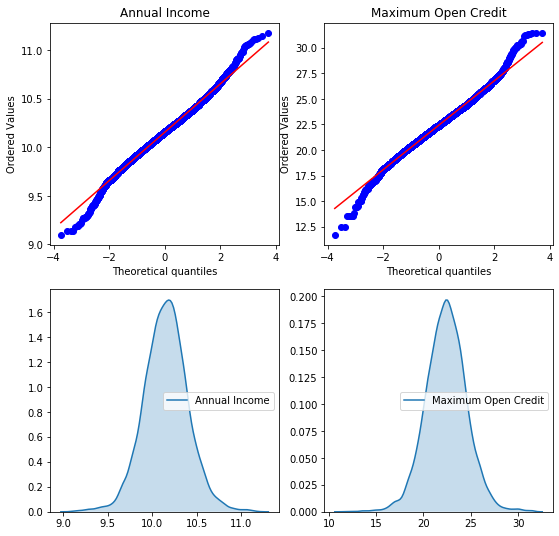

In [91]:
fig, axes=plt.subplots(ncols=2, nrows=2, figsize=(9,9))
ax1, ax2, ax3, ax4 = axes.flatten()
probplot(df['Annual Income'], dist='norm', plot=ax1)
ax1.set_title('Annual Income')
probplot(df['Maximum Open Credit'], dist='norm', plot=ax2)
ax2.set_title('Maximum Open Credit')
sns.kdeplot(df['Annual Income'], shade=True, label='Annual Income', ax=ax3)
sns.kdeplot(df['Maximum Open Credit'], shade=True, label='Maximum Open Credit', ax=ax4)

После преобразования Бокса Кокса отклонения хвостов стали значительно меньше от диагонали. Следовательно данные выровнялись.

### Матрица корреляций


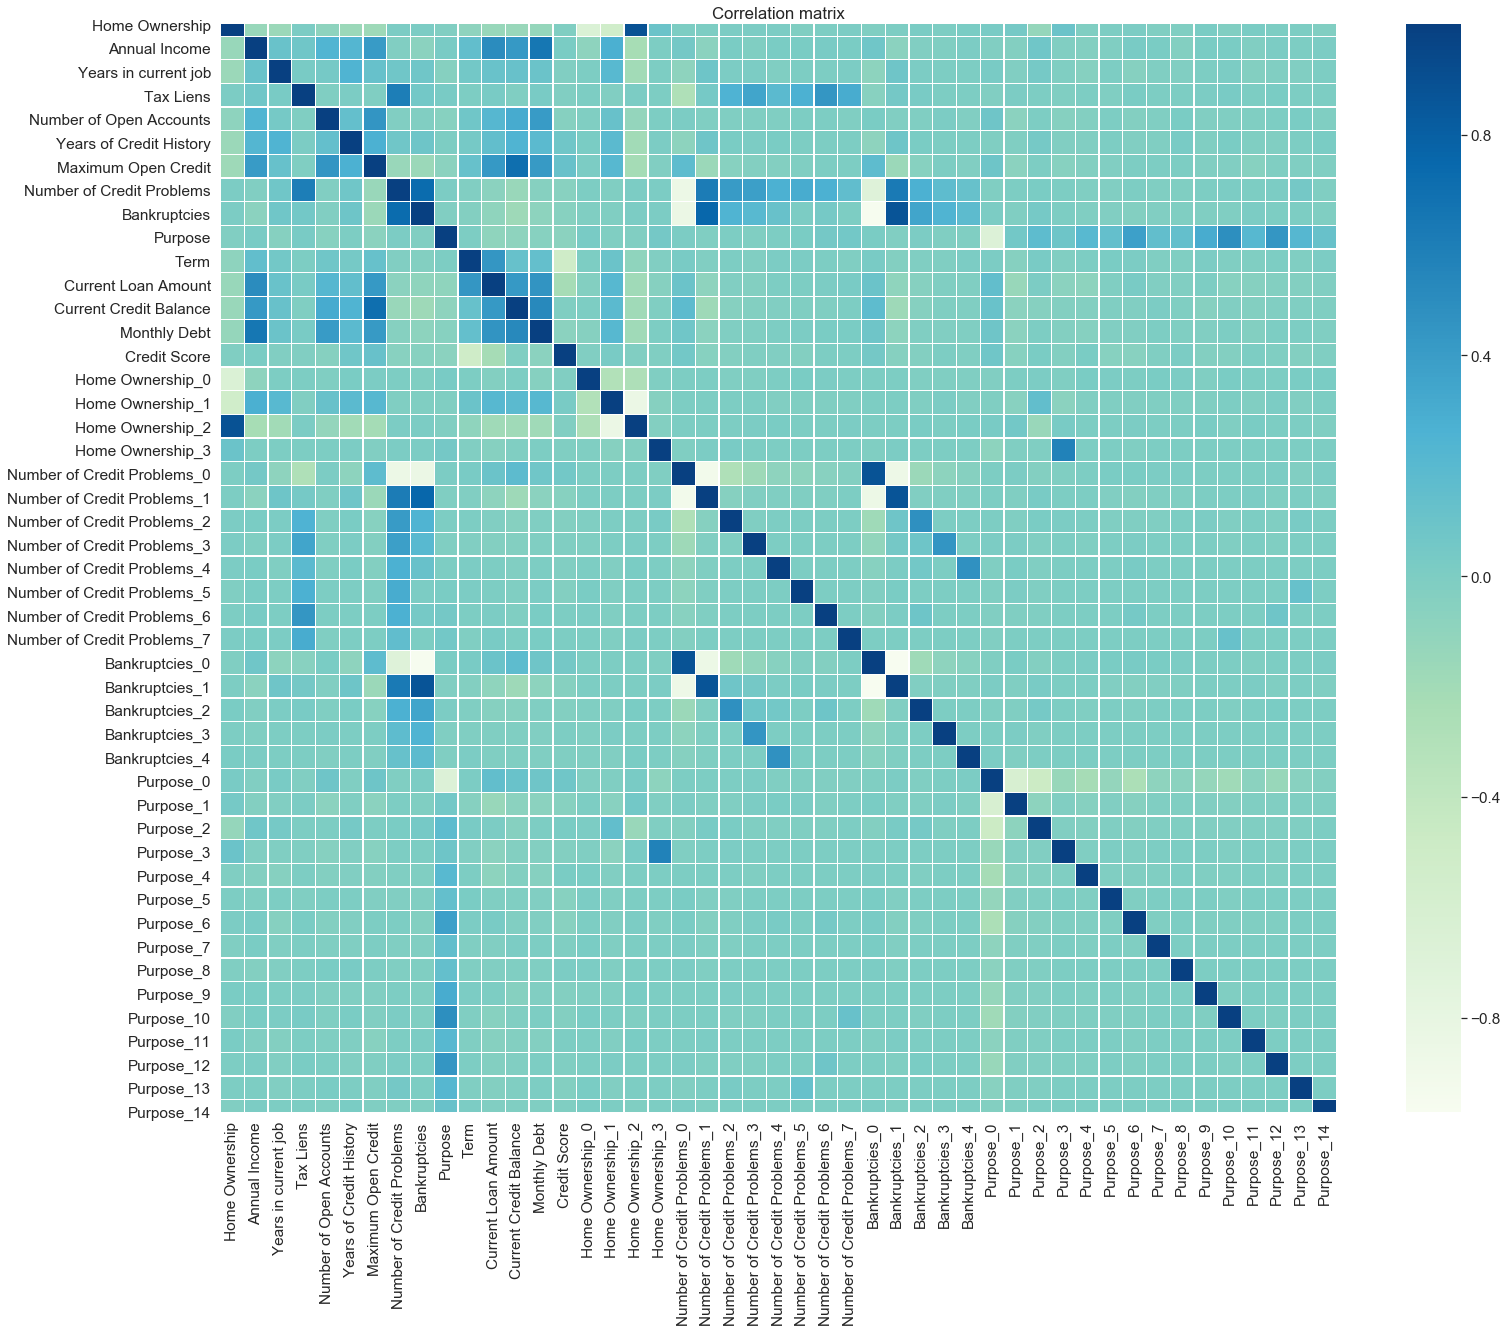

In [92]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES+NEW_FEATURE_NAMES].corr().round(2), annot=False, linewidths=.3, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [93]:
dcorr=df[BASE_FEATURE_NAMES+NEW_FEATURE_NAMES].corr()

##### Проверим какие признаки сильно коррелируют между собой

In [94]:
CorField = []
for i in dcorr:
    for j in dcorr.index[dcorr[i] > 0.5]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print ("%s  -->  %s: r^2=%f" % (i,j, dcorr[i][dcorr.index==j].values[0]))
    for j in dcorr.index[dcorr[i] < -0.5]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print ("%s  -->  %s: r^2=%f" % (i,j, dcorr[i][dcorr.index==j].values[0]))

Home Ownership  -->  Home Ownership_2: r^2=0.893964
Home Ownership  -->  Home Ownership_0: r^2=-0.651845
Home Ownership  -->  Home Ownership_1: r^2=-0.527019
Annual Income  -->  Current Loan Amount: r^2=0.501371
Annual Income  -->  Monthly Debt: r^2=0.646585
Tax Liens  -->  Number of Credit Problems: r^2=0.595339
Maximum Open Credit  -->  Current Credit Balance: r^2=0.700922
Bankruptcies  -->  Number of Credit Problems_1: r^2=0.757535
Bankruptcies  -->  Bankruptcies_1: r^2=0.871030
Bankruptcies  -->  Number of Credit Problems_0: r^2=-0.844397
Bankruptcies  -->  Bankruptcies_0: r^2=-0.958210
Purpose  -->  Purpose_0: r^2=-0.669271
Term  -->  Credit Score: r^2=-0.510520
Home Ownership_3  -->  Purpose_3: r^2=0.568543


In [95]:
remove_in_model=['Home Ownership','Years in current job','Tax Liens','Number of Credit Problems','Tax Liens_6','Tax Liens_7','Number of Credit','Problems_1']

#### МЕТОД ГЛАВНЫХ КОМПОНЕТ

Объединение признаков с помощью метода главных компонент снизило точность модели. В связи с этим от метода главнх компонент я отказался

# Построение моделей

In [96]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [97]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [98]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.4, 0.6, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [99]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [100]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Выделение целевой переменной и групп признаков


In [101]:
# убираем целевую перменную в TARGET_NAME
TARGET_NAME = 'Credit Default'

# выписываем имена  признаков  исходного дата сета
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).drop(['Months since last delinquent']).tolist()

# выписываем имена признаков нового дата сета таким образом, что из подготовленного 
# дата сета выкидываем имена старого дата сета и имя целевой переменной
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES+['ID']+['Purpose_14']).tolist()

FTR=BASE_FEATURE_NAMES+NEW_FEATURE_NAMES

### Отбор признаков

In [102]:
NUM_FEATURE_NAMES=[]
for name in FTR:
    if df[name].nunique()>100:
        NUM_FEATURE_NAMES.append(name)
NUM_FEATURE_NAMES

['Annual Income',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [103]:
CAT_FEATURE_NAMES=list(BASE_FEATURE_NAMES)
for _ in NUM_FEATURE_NAMES:
    try: CAT_FEATURE_NAMES.remove(_)
    except: continue
CAT_FEATURE_NAMES

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term']

In [104]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Нормирование данных

In [105]:
scalar_names=[]
for name in FTR:
    if df[name].nunique()>=10:
        scalar_names.append(name)
    elif name=='CredProb_Loan':
        scalar_names.append(name)

scalar_names

['Annual Income',
 'Years in current job',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Purpose',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [106]:
scaler = StandardScaler()

df_norm=df[FTR].copy()
df_norm[scalar_names]=scaler.fit_transform(df[scalar_names])
df_scale=df_norm.copy()

#### PCA

Метод главных компонент снизил точнотсь модели, поэтому от него пришлось отказаться

### Разбиение на train и test



In [135]:
SELECTED_FEATURE_NAMES.remove('Number of Credit Problems_6')

In [136]:
X = df_scale[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [108]:
y_train.value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [137]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [138]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов

In [139]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [140]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Подбор гиперпараметров

In [141]:
model_catb = catb.CatBoostClassifier(
   class_weights=[1, 1.55], 
    silent=True, 
    random_state=21)

In [142]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 10]}

### Обучение и оценка финальной модели

### Снижение степени переобучения

In [143]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=10,
                                      l2_leaf_reg=10, 
                                      class_weights=[1, 1.5],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3771
           1       0.93      0.99      0.96      2958

    accuracy                           0.97      6729
   macro avg       0.96      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1616
           1       0.39      0.47      0.43       634

    accuracy                           0.64      2250
   macro avg       0.58      0.59      0.58      2250
weighted avg       0.67      0.64      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1142  474
1                333  301


In [144]:
final_model.fit(X, y)

### Подбор оптимального размера выборки, кривая обучения

### Выбор порога вероятности для определения класса

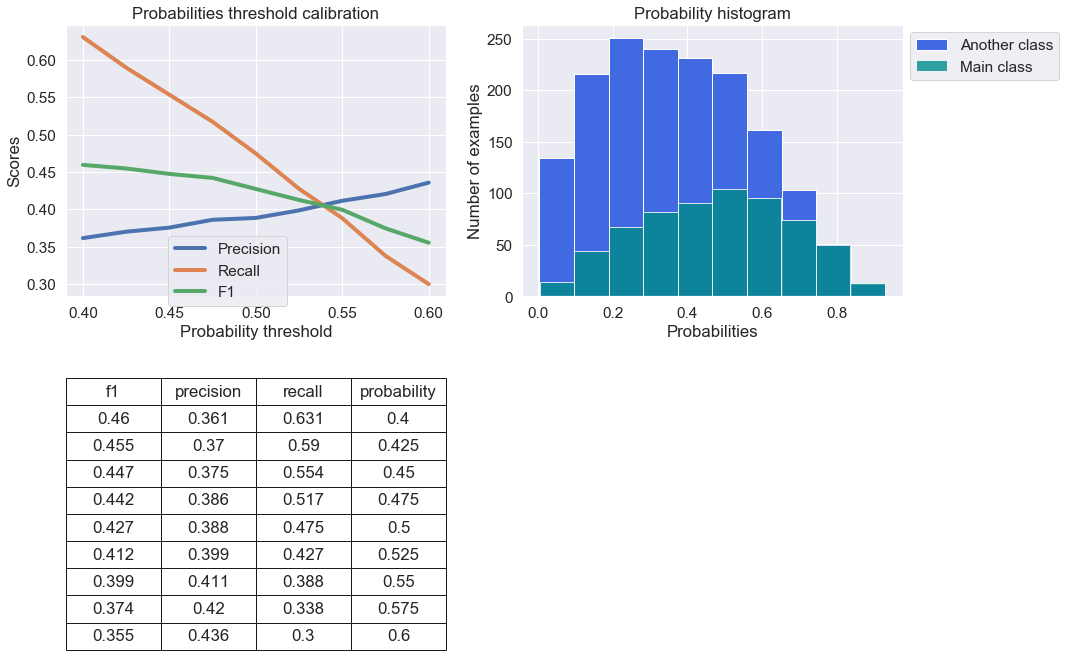

In [145]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков


## Тестовый дата сет

In [118]:
DATA_TEST_PATH="course_project_test.csv"
DATA_TEST_PATH_PREP="course_project_test_prep.csv"

In [119]:
dt=pd.read_csv(DATA_TEST_PATH)

In [120]:
dt.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [121]:
len(dt)-dt.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [122]:
# Преобразуем 'Years in current job'
ind=dt.loc[dt['Years in current job'].isna()==True,'Years in current job'].index

moda(dt,'Years in current job')
yearssmap(dt)


60      10
98      10
108     10
204     10
236     10
        ..
2352    10
2367    10
2402    10
2413    10
2464    10
Name: Years in current job, Length: 86, dtype: int64

In [123]:
# Преобразуем стороквые значения с помощью патернов
dt['Home Ownership']= converting(dt,'Home Ownership', HomeOwnershipPattern)
dt['Purpose']= converting(dt, 'Purpose', PurposePatern)
dt['Term'] =converting(dt,'Term',termpattern)

# Заменим пропущенные значения 'Bankruptcies'
moda(dt,'Bankruptcies')

# Выбросим 'Months since last delinquent'
dt.drop(['Months since last delinquent'],axis=1,inplace=True)

# Принимаем за границу выбросов значения больше 10**7 степени и заменяем их на медианные
dt.loc[dt['Maximum Open Credit']>=10**7,'Maximum Open Credit']=dt['Maximum Open Credit'].median()

# Заменим нулевые значения 'Maximum Open Credit' на медианные
dt.loc[dt['Maximum Open Credit']==0,'Maximum Open Credit']=dt['Maximum Open Credit'].median()

CredSc(dt)

dt.loc[dt['Current Loan Amount']==99999999.0,'Current Loan Amount']=None

# Заменим отсутствующие значения с помощью логистической регрессии
dt=regres(dt,'Credit Score',CrScore_Pat)
dt=regres(dt,'Annual Income',AnInc_Pat)
dt=regres(dt,'Current Loan Amount',CLA_Pat)

# Заменим нулевые значения и выбросы для 'Current Credit Balance'
dt.loc[dt['Current Credit Balance']==0,'Current Credit Balance']=dt['Current Loan Amount']
dt.loc[dt['Current Credit Balance']>=dt['Current Credit Balance'].max()*0.3,'Current Credit Balance']=dt['Current Loan Amount']

dt['ID'] = dt.index.tolist()

In [124]:
# Преобразуем в дамми переменные
posd=possible_dummies
dt[posd]=dt[posd].astype(np.int64)
for cat_colname in posd:
    dt = pd.concat([dt, pd.get_dummies(dt[cat_colname], prefix=cat_colname)], axis=1)

In [125]:
FTR.remove('Number of Credit Problems_6')

In [126]:
# Нормируем данные 
dt_norm=dt[FTR].copy()
dt_norm[scalar_names]=scaler.transform(dt[scalar_names])
dt_scale=dt_norm.copy()

In [130]:
dt_scale.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
Home Ownership,2500.0,1.0,1.0,0.0,1.0,1.0,2.0,3.0
Annual Income,2500.0,5468911.0,3389581.0,426828.0,3571316.0,4848808.0,6508531.0,60005995.0
Years in current job,2500.0,0.0,1.0,-2.0,-1.0,-0.0,1.0,1.0
Tax Liens,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
Number of Open Accounts,2500.0,0.0,1.0,-2.0,-1.0,-0.0,1.0,8.0
Years of Credit History,2500.0,0.0,1.0,-2.0,-1.0,-0.0,1.0,5.0
Maximum Open Credit,2500.0,302999.0,318044.0,2031.0,129649.0,219806.0,366157.0,3992893.0
Number of Credit Problems,2500.0,0.0,1.0,0.0,0.0,0.0,0.0,15.0
Bankruptcies,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
Purpose,2500.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,7.0


# НЕ МАСШТАБИРУЮТСЯ ДВА ПРИЗНАКА

In [146]:
X_pred = dt_scale[SELECTED_FEATURE_NAMES]

In [147]:
y_pred = final_model.predict(X_pred)

In [151]:
y_pred=pd.DataFrame(y_pred,columns=['y_pred'])

In [156]:
y_pred.to_csv(FINAL_PATH,index=False, encoding='utf-8')